---
# **Assignment One: Reinforcement Learning**
---

## Context:
The goal of this exercise is to solve the inverted pendulum problem using reinforcement learning. The inverted pendulum swing-up problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.
To solve this problem, implement the Deep Deterministic Policy Gradient (DDPG) algorithm in a python class and provide a script that coordinates the interaction between the agent and the environment. Please provides figures that capture the learning behavior of the agent. The applicant is expected to use the
Pendulum-v0 environment provided by OpenAI gym.


---
## **Importing necessary libraries**
---

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from collections import deque 
import gym
from gym import Wrapper
import matplotlib.pyplot as plt


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
## **Actor Class**
---

In [ ]:
class Actor(tf.keras.Model):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound

        self.layer1 = Dense(256, activation='relu')
        self.layer2 = Dense(256, activation='relu')
        self.layer3 = Dense(action_dim, activation='tanh')

    def call(self, state):
        x = self.layer1(state)
        x = self.layer2(x)
        x = self.layer3(x)
        return tf.multiply(x, self.action_bound)

---
## **Critic Class**
---

In [ ]:
class Critic(tf.keras.Model):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.state_layer1 = Dense(16, activation='relu')
        self.state_layer2 = Dense(32, activation='relu')

        self.action_layer1 = Dense(256, activation='relu')

        self.concat_layer = Dense(256, activation='relu')
        self.layer_out = Dense(1)

    def call(self, state, action):
        state_out = self.state_layer1(state)
        state_out = self.state_layer2(state_out)

        action_out = self.action_layer1(action)

        concat = tf.concat([state_out, action_out], axis=-1)
        x = self.concat_layer(concat)
        x = self.layer_out(x)
        return x


---
## **Agent Class**
---

In [ ]:
class DDPGAgent:
    def __init__(self, env, actor_learning_rate=0.001, critic_learning_rate=0.002):
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_bound = env.action_space.high[0]

        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound)
        self.actor_target = Actor(self.state_dim, self.action_dim, self.action_bound)

        self.critic = Critic(self.state_dim, self.action_dim)
        self.critic_target = Critic(self.state_dim, self.action_dim)

        # Use custom learning rates for the actor and critic
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_learning_rate)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_learning_rate)

        self.tau = 0.005

    def policy(self, state):
        state = np.expand_dims(state, axis=0)
        return self.actor(state).numpy()[0]


    def train(self, replay_buffer, batch_size=64):
        # Sample experience from the replay buffer
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)

        # Update critic
        with tf.GradientTape() as tape:
            target_actions = self.actor_target(next_state_batch)
            target_q_values = self.critic_target(next_state_batch, target_actions)
            y = reward_batch + (1 - done_batch) * 0.99 * target_q_values
            q_values = self.critic(state_batch, action_batch)
            critic_loss = tf.keras.losses.MSE(y, q_values)

        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

        # Update actor
        with tf.GradientTape() as tape:
            actions = self.actor(state_batch)
            q_values = self.critic(state_batch, actions)
            actor_loss = -tf.reduce_mean(q_values)

        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))

        # Perform soft update of the target networks
        for target_var, var in zip(self.actor_target.trainable_variables, self.actor.trainable_variables):
            target_var.assign((1 - self.tau) * target_var + self.tau * var)

        for target_var, var in zip(self.critic_target.trainable_variables, self.critic.trainable_variables):
            target_var.assign((1 - self.tau) * target_var + self.tau * var)



---
## **Buffer Class**
---

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


---
## **Driver Code: Main Loop**
---

Episode 1, Ep-Reward: -1065.8117158026496, Avg-Rewared: -1065.8117158026496
Episode 2, Ep-Reward: -891.3300087740811, Avg-Rewared: -978.5708622883653
Episode 3, Ep-Reward: -1071.686793387436, Avg-Rewared: -1009.6095059880555
Episode 4, Ep-Reward: -1551.4846680243927, Avg-Rewared: -1145.07829649714
Episode 5, Ep-Reward: -1394.4252263477094, Avg-Rewared: -1194.9476824672538
Episode 6, Ep-Reward: -1145.1649997502625, Avg-Rewared: -1186.6505686810885
Episode 7, Ep-Reward: -1318.5069680901477, Avg-Rewared: -1205.487197168097
Episode 8, Ep-Reward: -1510.2290337968068, Avg-Rewared: -1243.5799267466857
Episode 9, Ep-Reward: -1220.7170348723482, Avg-Rewared: -1241.0396054273149
Episode 10, Ep-Reward: -1150.4071641173675, Avg-Rewared: -1231.9763612963202
Episode 11, Ep-Reward: -970.3311012750207, Avg-Rewared: -1208.190428567111
Episode 12, Ep-Reward: -1063.3366491830234, Avg-Rewared: -1196.1192802851037
Episode 13, Ep-Reward: -861.5114331632765, Avg-Rewared: -1170.3802151218863
Episode 14, Ep-Re

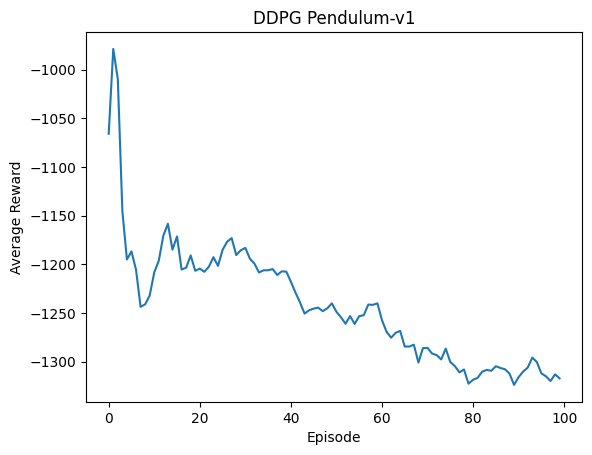

In [ ]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')

    # Pass custom learning rates for the actor and critic
    actor_learning_rate = 0.001
    critic_learning_rate = 0.002

    agent = DDPGAgent(env, actor_learning_rate, critic_learning_rate)
    replay_buffer = ReplayBuffer(max_size=100000)

    num_episodes = 100
    batch_size = 64
    episode_reward_list = []
    avg_reward_list = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        best_score = -1000

        while True:
            action = agent.policy(state)

            # Add exploration noise
            noise = np.random.normal(0, 0.2, size=env.action_space.shape[0])
            action = np.clip(action + noise, env.action_space.low, env.action_space.high)

            next_state, reward, done, _ = env.step(action)

            replay_buffer.add(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward

            if len(replay_buffer.buffer) >= batch_size:
                agent.train(replay_buffer, batch_size)

            if done:
                if episode_reward > best_score:
                  best_score = episode_reward
                break

        episode_reward_list.append(episode_reward)
        avg_reward = np.mean(episode_reward_list[-50:])
        avg_reward_list.append(avg_reward)
        print(f"Episode {episode + 1}, Ep-Reward: {episode_reward}, Avg-Rewared: {avg_reward}")

    # Plot the average reward for each episode
    plt.plot(avg_reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('DDPG Pendulum-v1')
    plt.show()


---
## **Convert notbook to HTML file**
---

In [1]:
# access the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# convert to html
%%shell
jupyter nbconvert --to html ///content/drive/MyDrive/JLAB/RL_DDPG/RL_DDPG.ipynb

[NbConvertApp] Converting notebook ///content/drive/MyDrive/JLAB/RL_DDPG/RL_DDPG.ipynb to html
[NbConvertApp] Writing 670353 bytes to /content/drive/MyDrive/JLAB/RL_DDPG/RL_DDPG.html
